In [35]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

import torch
import torchvision

from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models

import copy
import time

import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.image import imread

import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [36]:


!mkdir /kaggle/working/Corn
!mkdir /kaggle/working/Corn/test
!mkdir /kaggle/working/Corn/train

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Corn* /kaggle/working/Corn/test
!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Corn* /kaggle/working/Corn/train



transfrom = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
    ])

train_path='/kaggle/working/Corn/train'
test_path='/kaggle/working/Corn/test'
BATCH_SIZE=32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_dataset=ImageFolder(test_path,transform=transfrom)
train_dataset=ImageFolder(train_path,transform=transfrom)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# dataset=ImageFolder(path,transform=transfrom)

# train_dataset,test_dataset=train_test_split(dataset,test_size=0.2,shuffle=True,random_state=43)

batch_size = 32
n_iters = 20000
num_epochs = n_iters / (len(train_dataset) / batch_size)

# train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)

# val_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

mkdir: cannot create directory ‘/kaggle/working/Corn’: File exists
mkdir: cannot create directory ‘/kaggle/working/Corn/test’: File exists
mkdir: cannot create directory ‘/kaggle/working/Corn/train’: File exists


In [42]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
#         self.mish1 = nn.Mish()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
#         self.mish2 = nn.Mish()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*56*56, 4)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
#         out = self.mish1(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
#         out = self.mish2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
model = NeuralNetwork()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
# optimizer_ft = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [43]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [44]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [45]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [46]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
# epochs=40
for epoch in range(1,int(num_epochs)+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 386/386 [00:35<00:00, 10.91it/s]


Train Loss: 1.342 | Accuracy: 31.617


100%|██████████| 97/97 [00:08<00:00, 11.29it/s]


Test Loss: 1.312 | Accuracy: 30.169

Epoch : 2


100%|██████████| 386/386 [00:35<00:00, 10.98it/s]


Train Loss: 1.305 | Accuracy: 31.844


100%|██████████| 97/97 [00:08<00:00, 11.73it/s]


Test Loss: 1.286 | Accuracy: 34.330

Epoch : 3


100%|██████████| 386/386 [00:35<00:00, 10.91it/s]


Train Loss: 1.274 | Accuracy: 41.583


100%|██████████| 97/97 [00:08<00:00, 10.84it/s]


Test Loss: 1.248 | Accuracy: 43.303

Epoch : 4


100%|██████████| 386/386 [00:35<00:00, 10.99it/s]


Train Loss: 1.228 | Accuracy: 49.416


100%|██████████| 97/97 [00:08<00:00, 11.78it/s]


Test Loss: 1.192 | Accuracy: 48.960

Epoch : 5


100%|██████████| 386/386 [00:35<00:00, 10.95it/s]


Train Loss: 1.164 | Accuracy: 53.463


100%|██████████| 97/97 [00:08<00:00, 11.74it/s]


Test Loss: 1.121 | Accuracy: 52.503

Epoch : 6


100%|██████████| 386/386 [00:34<00:00, 11.07it/s]


Train Loss: 1.087 | Accuracy: 56.739


100%|██████████| 97/97 [00:09<00:00, 10.63it/s]


Test Loss: 1.039 | Accuracy: 60.696

Epoch : 7


100%|██████████| 386/386 [00:34<00:00, 11.08it/s]


Train Loss: 1.010 | Accuracy: 62.034


100%|██████████| 97/97 [00:08<00:00, 11.91it/s]


Test Loss: 0.961 | Accuracy: 62.646

Epoch : 8


100%|██████████| 386/386 [00:34<00:00, 11.13it/s]


Train Loss: 0.932 | Accuracy: 66.534


100%|██████████| 97/97 [00:08<00:00, 11.68it/s]


Test Loss: 0.894 | Accuracy: 66.873

Epoch : 9


100%|██████████| 386/386 [00:34<00:00, 11.05it/s]


Train Loss: 0.869 | Accuracy: 70.037


100%|██████████| 97/97 [00:08<00:00, 10.85it/s]


Test Loss: 0.823 | Accuracy: 71.359

Epoch : 10


100%|██████████| 386/386 [00:34<00:00, 11.11it/s]


Train Loss: 0.809 | Accuracy: 71.627


100%|██████████| 97/97 [00:08<00:00, 11.65it/s]


Test Loss: 0.776 | Accuracy: 72.594

Epoch : 11


100%|██████████| 386/386 [00:34<00:00, 11.10it/s]


Train Loss: 0.761 | Accuracy: 73.127


100%|██████████| 97/97 [00:08<00:00, 11.90it/s]


Test Loss: 0.735 | Accuracy: 72.562

Epoch : 12


100%|██████████| 386/386 [00:34<00:00, 11.17it/s]


Train Loss: 0.723 | Accuracy: 73.289


100%|██████████| 97/97 [00:08<00:00, 10.86it/s]


Test Loss: 0.696 | Accuracy: 73.407

Epoch : 13


100%|██████████| 386/386 [00:34<00:00, 11.11it/s]


Train Loss: 0.687 | Accuracy: 74.465


100%|██████████| 97/97 [00:08<00:00, 11.88it/s]


Test Loss: 0.671 | Accuracy: 74.090

Epoch : 14


100%|██████████| 386/386 [00:35<00:00, 10.94it/s]


Train Loss: 0.667 | Accuracy: 74.222


100%|██████████| 97/97 [00:07<00:00, 12.15it/s]


Test Loss: 0.649 | Accuracy: 75.163

Epoch : 15


100%|██████████| 386/386 [00:35<00:00, 11.03it/s]


Train Loss: 0.641 | Accuracy: 74.943


100%|██████████| 97/97 [00:08<00:00, 11.29it/s]


Test Loss: 0.640 | Accuracy: 74.740

Epoch : 16


100%|██████████| 386/386 [00:34<00:00, 11.04it/s]


Train Loss: 0.636 | Accuracy: 74.651


100%|██████████| 97/97 [00:07<00:00, 12.16it/s]


Test Loss: 0.616 | Accuracy: 75.650

Epoch : 17


100%|██████████| 386/386 [00:34<00:00, 11.19it/s]


Train Loss: 0.621 | Accuracy: 75.008


100%|██████████| 97/97 [00:08<00:00, 11.42it/s]


Test Loss: 0.634 | Accuracy: 75.325

Epoch : 18


100%|██████████| 386/386 [00:34<00:00, 11.11it/s]


Train Loss: 0.608 | Accuracy: 75.657


100%|██████████| 97/97 [00:08<00:00, 11.06it/s]


Test Loss: 0.600 | Accuracy: 76.235

Epoch : 19


100%|██████████| 386/386 [00:35<00:00, 10.99it/s]


Train Loss: 0.605 | Accuracy: 75.178


100%|██████████| 97/97 [00:08<00:00, 11.70it/s]


Test Loss: 0.603 | Accuracy: 75.293

Epoch : 20


100%|██████████| 386/386 [00:35<00:00, 10.97it/s]


Train Loss: 0.591 | Accuracy: 75.673


100%|██████████| 97/97 [00:08<00:00, 11.75it/s]


Test Loss: 0.584 | Accuracy: 76.463

Epoch : 21


100%|██████████| 386/386 [00:35<00:00, 11.00it/s]


Train Loss: 0.587 | Accuracy: 75.568


100%|██████████| 97/97 [00:08<00:00, 11.62it/s]


Test Loss: 0.595 | Accuracy: 76.203

Epoch : 22


100%|██████████| 386/386 [00:35<00:00, 10.94it/s]


Train Loss: 0.589 | Accuracy: 75.843


100%|██████████| 97/97 [00:08<00:00, 11.76it/s]


Test Loss: 0.581 | Accuracy: 76.268

Epoch : 23


100%|██████████| 386/386 [00:35<00:00, 10.86it/s]


Train Loss: 0.577 | Accuracy: 76.224


100%|██████████| 97/97 [00:08<00:00, 11.52it/s]


Test Loss: 0.571 | Accuracy: 76.333

Epoch : 24


100%|██████████| 386/386 [00:35<00:00, 11.00it/s]


Train Loss: 0.580 | Accuracy: 75.876


100%|██████████| 97/97 [00:08<00:00, 11.54it/s]


Test Loss: 0.595 | Accuracy: 75.423

Epoch : 25


100%|██████████| 386/386 [00:35<00:00, 10.77it/s]


Train Loss: 0.570 | Accuracy: 76.233


100%|██████████| 97/97 [00:08<00:00, 11.64it/s]


Test Loss: 0.565 | Accuracy: 76.691

Epoch : 26


100%|██████████| 386/386 [00:35<00:00, 10.99it/s]


Train Loss: 0.561 | Accuracy: 76.565


100%|██████████| 97/97 [00:08<00:00, 11.68it/s]


Test Loss: 0.566 | Accuracy: 76.625

Epoch : 27


100%|██████████| 386/386 [00:35<00:00, 11.02it/s]


Train Loss: 0.560 | Accuracy: 76.670


100%|██████████| 97/97 [00:08<00:00, 11.75it/s]


Test Loss: 0.561 | Accuracy: 76.593

Epoch : 28


100%|██████████| 386/386 [00:34<00:00, 11.08it/s]


Train Loss: 0.550 | Accuracy: 76.857


100%|██████████| 97/97 [00:08<00:00, 10.92it/s]


Test Loss: 0.557 | Accuracy: 77.341

Epoch : 29


100%|██████████| 386/386 [00:35<00:00, 10.87it/s]


Train Loss: 0.558 | Accuracy: 76.297


100%|██████████| 97/97 [00:08<00:00, 11.67it/s]


Test Loss: 0.544 | Accuracy: 78.056

Epoch : 30


100%|██████████| 386/386 [00:34<00:00, 11.12it/s]


Train Loss: 0.545 | Accuracy: 77.271


100%|██████████| 97/97 [00:08<00:00, 11.83it/s]


Test Loss: 0.557 | Accuracy: 77.568

Epoch : 31


100%|██████████| 386/386 [00:34<00:00, 11.13it/s]


Train Loss: 0.546 | Accuracy: 77.116


100%|██████████| 97/97 [00:08<00:00, 10.86it/s]


Test Loss: 0.547 | Accuracy: 77.178

Epoch : 32


100%|██████████| 386/386 [00:35<00:00, 10.91it/s]


Train Loss: 0.544 | Accuracy: 76.995


100%|██████████| 97/97 [00:08<00:00, 11.58it/s]


Test Loss: 0.566 | Accuracy: 76.463

Epoch : 33


100%|██████████| 386/386 [00:35<00:00, 10.93it/s]


Train Loss: 0.544 | Accuracy: 77.173


100%|██████████| 97/97 [00:08<00:00, 11.74it/s]


Test Loss: 0.539 | Accuracy: 77.991

Epoch : 34


100%|██████████| 386/386 [00:35<00:00, 10.87it/s]


Train Loss: 0.541 | Accuracy: 77.303


100%|██████████| 97/97 [00:09<00:00, 10.70it/s]


Test Loss: 0.529 | Accuracy: 78.121

Epoch : 35


100%|██████████| 386/386 [00:35<00:00, 10.84it/s]


Train Loss: 0.530 | Accuracy: 77.684


100%|██████████| 97/97 [00:08<00:00, 11.62it/s]


Test Loss: 0.514 | Accuracy: 78.218

Epoch : 36


100%|██████████| 386/386 [00:35<00:00, 10.92it/s]


Train Loss: 0.518 | Accuracy: 77.952


100%|██████████| 97/97 [00:08<00:00, 11.43it/s]


Test Loss: 0.534 | Accuracy: 77.893

Epoch : 37


100%|██████████| 386/386 [00:35<00:00, 11.03it/s]


Train Loss: 0.517 | Accuracy: 78.211


100%|██████████| 97/97 [00:08<00:00, 10.80it/s]


Test Loss: 0.515 | Accuracy: 77.893

Epoch : 38


100%|██████████| 386/386 [00:35<00:00, 10.93it/s]


Train Loss: 0.520 | Accuracy: 78.381


100%|██████████| 97/97 [00:08<00:00, 11.56it/s]


Test Loss: 0.510 | Accuracy: 78.674

Epoch : 39


100%|██████████| 386/386 [00:35<00:00, 10.91it/s]


Train Loss: 0.515 | Accuracy: 78.252


100%|██████████| 97/97 [00:08<00:00, 11.65it/s]


Test Loss: 0.506 | Accuracy: 78.316

Epoch : 40


100%|██████████| 386/386 [00:36<00:00, 10.61it/s]


Train Loss: 0.514 | Accuracy: 78.098


100%|██████████| 97/97 [00:08<00:00, 11.70it/s]


Test Loss: 0.518 | Accuracy: 77.861

Epoch : 41


100%|██████████| 386/386 [00:35<00:00, 10.79it/s]


Train Loss: 0.517 | Accuracy: 78.268


100%|██████████| 97/97 [00:08<00:00, 11.66it/s]


Test Loss: 0.520 | Accuracy: 77.276

Epoch : 42


100%|██████████| 386/386 [00:35<00:00, 11.01it/s]


Train Loss: 0.503 | Accuracy: 78.722


100%|██████████| 97/97 [00:08<00:00, 11.56it/s]


Test Loss: 0.510 | Accuracy: 78.804

Epoch : 43


100%|██████████| 386/386 [00:35<00:00, 10.96it/s]


Train Loss: 0.501 | Accuracy: 78.446


100%|██████████| 97/97 [00:08<00:00, 11.71it/s]


Test Loss: 0.497 | Accuracy: 79.584

Epoch : 44


100%|██████████| 386/386 [00:35<00:00, 10.95it/s]


Train Loss: 0.496 | Accuracy: 78.665


100%|██████████| 97/97 [00:08<00:00, 11.51it/s]


Test Loss: 0.507 | Accuracy: 78.771

Epoch : 45


100%|██████████| 386/386 [00:35<00:00, 10.99it/s]


Train Loss: 0.494 | Accuracy: 78.965


100%|██████████| 97/97 [00:08<00:00, 12.01it/s]


Test Loss: 0.501 | Accuracy: 78.739

Epoch : 46


100%|██████████| 386/386 [00:35<00:00, 10.86it/s]


Train Loss: 0.493 | Accuracy: 78.965


100%|██████████| 97/97 [00:07<00:00, 12.24it/s]


Test Loss: 0.485 | Accuracy: 79.064

Epoch : 47


100%|██████████| 386/386 [00:35<00:00, 10.77it/s]


Train Loss: 0.490 | Accuracy: 78.973


100%|██████████| 97/97 [00:08<00:00, 11.29it/s]


Test Loss: 0.481 | Accuracy: 79.454

Epoch : 48


100%|██████████| 386/386 [00:38<00:00, 10.05it/s]


Train Loss: 0.488 | Accuracy: 79.209


100%|██████████| 97/97 [00:09<00:00, 10.50it/s]


Test Loss: 0.501 | Accuracy: 78.771

Epoch : 49


100%|██████████| 386/386 [00:36<00:00, 10.44it/s]


Train Loss: 0.491 | Accuracy: 78.795


100%|██████████| 97/97 [00:08<00:00, 11.05it/s]


Test Loss: 0.492 | Accuracy: 79.681

Epoch : 50


100%|██████████| 386/386 [00:35<00:00, 10.87it/s]


Train Loss: 0.483 | Accuracy: 79.379


100%|██████████| 97/97 [00:08<00:00, 11.59it/s]


Test Loss: 0.491 | Accuracy: 79.064

Epoch : 51


100%|██████████| 386/386 [00:35<00:00, 10.79it/s]


Train Loss: 0.480 | Accuracy: 79.200


100%|██████████| 97/97 [00:09<00:00, 10.68it/s]

Test Loss: 0.486 | Accuracy: 78.934


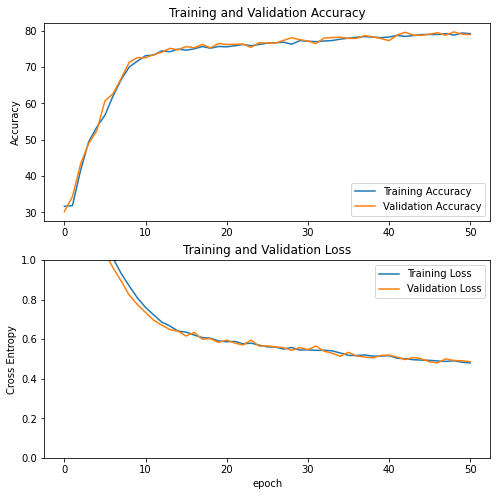

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [48]:
# !pip install playsound

# from playsound import playsound
  
# # for playing note.wav file
# playsound('/path/note.wav')
# print('playing sound using  playsound')

In [ ]:
# import os, os.path

# # simple version for working with CWD
# print len([name for name in os.listdir('') if os.path.isfile(name)])

In [49]:
torch.save(model.state_dict(), '/kaggle/working/CornModelupdatedoutchannels.pk1')

In [50]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('CornModelupdatedoutchannels.pt') # Save

import os 
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'CornModelupdatedoutchannels.pt')

import os 
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'CornModelupdatedoutchannels.pk1')

/kaggle/working/CornModelupdatedoutchannels.pk1